In [1]:
import pandas as pd
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
import os

In [86]:
dire = 'E:/工作/模型/人行模型/'
os.chdir(dire)

In [3]:
def peek(df, line=None):
    print(df.shape)
    if line is None:
        print(df.head())
    else:
        print(df.head(line))

In [49]:
hf_parsed = pd.read_csv("./data/hf_success_parsed.csv")
peek(hf_parsed, 2)

(5473, 84)
                    id          customer_unique_key  \
0  1565045748508688384  C20230222283540087663378523   
1  1565061112885968896  C20230222283555465470820448   

                     serial_no              create_time            edit_time  \
0  S20230222283540163546722360  2023-02-22T10:07:24.091  2023-02-23T00:30:25   
1  S20230222283555531266867255  2023-02-22T11:08:27.244  2023-02-23T00:30:40   

  dm_id_003 dm_id_005 dm_id_009  dm_summary_001  dm_summary_002  \
0        ZZ       NaN        ZZ               0             0.0   
1        XX        YH      QYGL               0             0.0   

   dm_summary_003  dm_summary_004  dm_summary_005  dm_summary_006  \
0               0               4       1004.6718       1003.6697   
1               0               1          0.0000        988.0811   

   dm_summary_007  dm_summary_011  dm_summary_012  dm_summary_013  \
0       1008.5495        995.0576        990.5543               0   
1        997.0322        997.0596 

查看数据空值分布情况

In [51]:
msno.matrix(hf_parsed).set_title("hf_parsed", fontsize=20)

Text(0.5, 1.0, 'hf_parsed')

查看有哪些类别特征

In [52]:
cat_features = hf_parsed.select_dtypes("object").columns
print(*cat_features, sep=", ")

customer_unique_key, serial_no, create_time, edit_time, dm_id_003, dm_id_005, dm_id_009, dm_creditdetails_007, dm_repayment_1_001, dm_repayment_25_001, dm_repayment_2_001, dm_repayment_15_001, serial_no.1


In [53]:
hf_parsed['dm_id_003'].unique()

array(['ZZ', 'XX', 'DZ', nan, 'QT', 'GZ', 'BK', 'YJS'], dtype=object)

In [54]:
hf_parsed['dm_id_005'].unique()

array([nan, 'YH'], dtype=object)

In [55]:
hf_parsed['dm_id_009'].unique()

array(['ZZ', 'QYGL', 'QT', nan, 'ZY', 'WYRH', 'ZYJS', 'GTJY', 'ZYZY',
       'NM', 'GWY', 'XS', 'GR', 'JR'], dtype=object)

这些特征展示客户近两年或五年每个月的逾期情况，如下图所示，其中N和A合并成"/"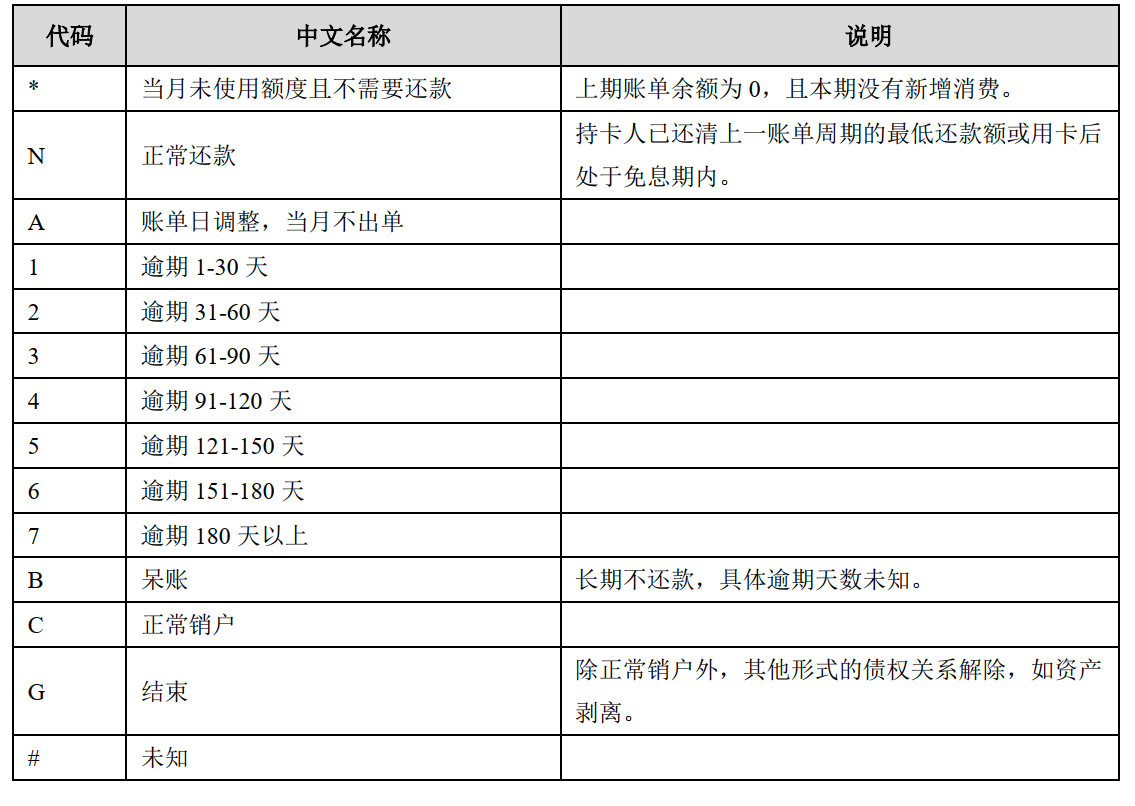

In [21]:
peek(hf_parsed.filter(regex="dm_repayment"), 2)

(5473, 4)
         dm_repayment_1_001  \
0  ///////*0000000000000000   
1  /////*0000000***000000*/   

                                 dm_repayment_25_001  \
0  //////////////////////////////////////////////...   
1  ////////////////*00000C**0000C0000C0000000C000...   

         dm_repayment_2_001                                dm_repayment_15_001  
0  ////////////////////////  ///////////////////////////////////////////*00...  
1  000000C0000000C0C000C000  000C0000000**********C///////////////////*0000...  


dm_creditdetails_007表示还款率超9的客户占比，需要转化为比例，并把分子（还款率超9的客户数）提出来

In [49]:
hf_parsed['dm_creditdetails_007'].unique()

array(['3/4', '0/0', '5/8', '0/3', '1/1', '0/1', '0/2', '3/3', '1/5',
       '3/5', '0/7', '-9990996', '0/12', '1/2', '0/10', '2/3', '2/2',
       '6/6', '1/4', '0/4', '4/5', '4/7', '10/10', '2/5', '7/7', '4/4',
       '2/4', '1/3', '1/6', '4/8', '8/9', '3/6', '4/11', '5/6', '7/8',
       '4/6', '2/8', '5/9', nan, '6/8', '1/12', '0/6', '0/5', '2/7',
       '6/9', '1/10', '4/13', '1/8', '2/14', '5/5', '8/11', '2/6', '2/11',
       '9/9', '3/10', '3/11', '3/8', '7/10', '5/7', '4/12', '6/10', '6/7',
       '3/7', '7/9', '2/13', '5/10', '2/9', '8/10', '5/12', '0/8', '1/9',
       '1/7', '3/9', '11/11', '0/9', '1/11', '7/12', '9/12', '9/10',
       '12/15', '3/12', '4/9', '7/11', '5/13', '10/13', '8/8', '13/13',
       '6/13', '4/10', '12/13', '0/11', '2/12', '6/11', '10/12', '5/15',
       '9/14', '2/10', '10/11', '5/11', '9/11', '0/13', '0/15', '8/13',
       '3/14'], dtype=object)

In [50]:
pd.notnull(hf_parsed['dm_creditdetails_007']).sum()

4605

In [12]:
sum(hf_parsed['dm_creditdetails_007'] == '-9990996')

237

查看数值变量的分布情况

In [54]:
hf_parsed.describe()

,id,dm_summary_001,dm_summary_002,dm_summary_003,dm_summary_004,dm_summary_005,dm_summary_006,dm_summary_007,dm_summary_011,dm_summary_012,dm_summary_013,dm_summary_014,dm_summary_015,dm_summary_018,dm_summary_021,dm_summary_022,dm_summary_023,dm_summary_024,dm_summary_025,dm_creditdetails_001,dm_creditdetails_003,dm_creditdetails_004,dm_creditdetails_005,dm_creditdetails_006,dm_creditdetails_009,dm_creditdetails_011,dm_creditdetails_012,dm_creditdetails_013,dm_creditdetails_029,dm_creditdetails_030,dm_creditdetails_031,dm_creditdetails_032,dm_creditdetails_034,dm_publicdetails_001,dm_publicdetails_002,dm_publicdetails_003,dm_publicdetails_008,dm_publicdetails_009,dm_creditdetails_017,dm_creditdetails_024,dm_creditdetails_028,dm_qc_sc_01,dm_qc_sc_02,dm_qc_sc_03,dm_qc_sc_04,dm_qc_sc_05,dm_ql_sc_01,dm_ql_sc_02,dm_ql_sc_03,dm_ql_sc_04,dm_ql_sc_05,dm_qdb_sc_01,dm_qdb_sc_02,dm_qdb_sc_03,dm_qdb_sc_04,dm_qdb_sc_05,dm_qc_so_01,dm_qc_so_02,dm_qc_so_03,dm_qc_so_04,dm_qc_so_05,dm_ql_so_01,dm_ql_so_02,dm_ql_so_03,dm_ql_so_04,dm_ql_so_05,dm_qdb_so_01,dm_qdb_so_02,dm_qdb_so_03,dm_qdb_so_04,dm_qdb_so_05
count,5.473000e+03,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.00000,5473.000000,5473.000000,5473.000000,5473.0,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.0,5473.0,5473.0,5473.000000,5473.000000,5473.000000,5473.0,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000
mean,1.543210e+18,0.742920,292.412899,0.643340,2.342956,548.193768,559.048992,604.321589,580.469688,485.687330,0.922346,300.07234,1.109629,593.239275,0.096108,0.0,0.031792,0.067239,4.317559,1152.467751,4410.223826,15585.163530,3564.285218,2761.049772,0.061940,9.848895,10.279189,2.363603,0.036178,0.117120,62.405548,91.170401,444.320941,0.0,0.0,0.0,5.548694,54.047417,0.147634,0.0,77.011614,1.054997,1.588525,2.225653,3.285218,4.938608,0.896401,1.911749,3.200987,5.283391,9.210305,0.076010,0.162434,0.283757,0.508862,0.714234,1.047141,1.506852,1.983738,2.674036,3.585967,0.874475,1.759181,2.704732,3.982459,6.131189,0.074913,0.155308,0.220903,0.315366,0.381509
std,1.074097e+16,1.666847,453.780909,1.348312,2.938679,525.860602,522.243026,528.017563,503.178372,496.805829,1.974990,460.21420,2.536078,488.716202,0.543006,0.0,0.271875,0.285894,6.504526,12072.483792,15263.877847,37731.909559,15886.803547,5704.934027,0.241069,32.018544,20.354279,3.937571,0.186749,0.579235,240.618135,286.295012,1161.822835,0.0,0.0,0.0,30.830889,225.252497,0.413742,0.0,268.049690,1.322216,1.922634,2.659266,3.996338,6.077403,1.546682,2.585539,3.927591,6.199731,10.882168,0.298749,0.467628,0.711015,1.171030,1.628009,1.300854,1.728565,2.122162,2.610093,3.223458,1.489042,2.288998,3.071244,4.153451,6.052188,0.292226,0.436792,0.528073,0.643467,0.719076
min,1.532219e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.532555e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

- 这些字段需要做反向转换以获取原始值：取整((原始数值-987) * 100)*10，dm_summary_002dm_summary_005，dm_summary_006，dm_summary_007，dm_summary_011，dm_summary_012，dm_summary_014，dm_summary_018，dm_creditdetails_031，dm_creditdetails_032，dm_creditdetails_034，dm_publicdetails_009，dm_creditdetails_028
- dm_repayment*字段转化为逾期占比

In [57]:
reverse_vars = ['dm_summary_002', 'dm_summary_005','dm_summary_006','dm_summary_007','dm_summary_011','dm_summary_012',
               'dm_summary_014','dm_summary_018','dm_creditdetails_031','dm_creditdetails_032','dm_creditdetails_034',
               'dm_publicdetails_009','dm_creditdetails_028']
hf_parsed[reverse_vars] = hf_parsed[reverse_vars].applymap(lambda x: int((x-987) * 100) * 10 if x > 0 else 0)

观察以下变量的分布情况：dm_summary_002, dm_summary_005, dm_summary_006, dm_summary_007, dm_summary_011, dm_summary_012 , dm_summary_014, dm_summary_018, dm_credidetails_001, dm_creditdetails_003, dm_creditdetails_004, dm_creditdetails_005, dm_creditdetails_006, dm_creditdetails_030, dm_creditdetails_031, dm_creditdetails_032, dm_creditdetails_034，大部分变量存在重尾分布的情况

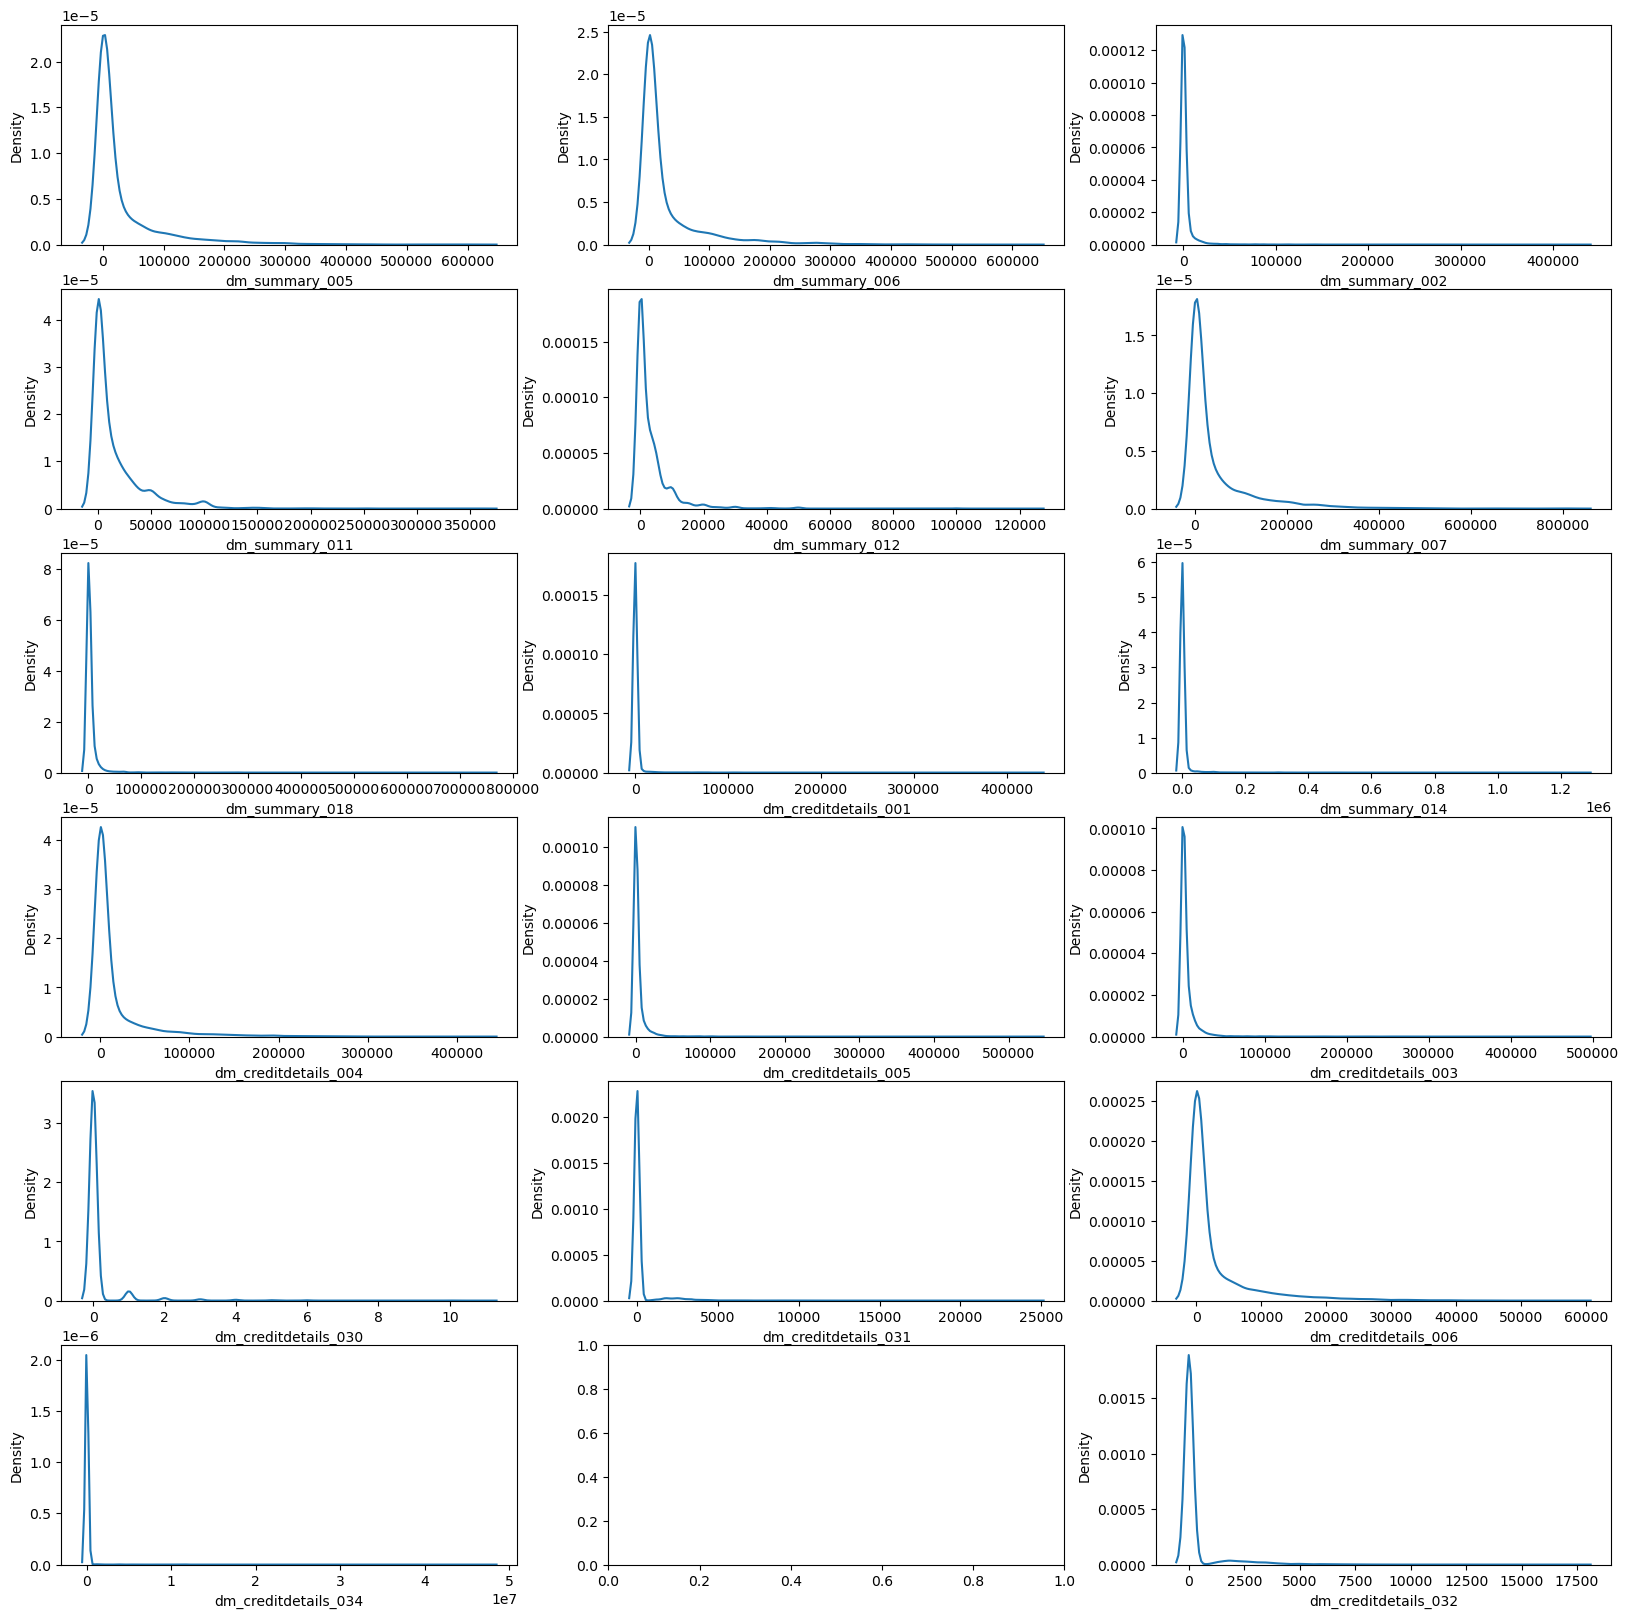

In [62]:
num_vars = ['dm_summary_002', 'dm_summary_005', 'dm_summary_006', 'dm_summary_007', 'dm_summary_011', 'dm_summary_012' , 
            'dm_summary_014', 'dm_summary_018', 'dm_creditdetails_001', 'dm_creditdetails_003', 'dm_creditdetails_004', 
            'dm_creditdetails_005', 'dm_creditdetails_006', 'dm_creditdetails_030', 'dm_creditdetails_031', 'dm_creditdetails_032', 
            'dm_creditdetails_034']

plt.close()
figure, axs = plt.subplots(6, 3, figsize=(20, 20))
for i, var in enumerate(num_vars):
    sns.kdeplot(hf_parsed[var], ax=axs[int(i / 3), (i % 3) - 1])
plt.show()

观察变量相关性
- dm_summary_022, dm_publicdetails_001, dm_publicdetails_002, dm_publicdetails_003, dm_creditdetails_024 全部值为0，排除观察\
- dm_qc_sc/so，dm_qdb_sc/so，dm_ql_sc/so, dm_summary变量具有较高的相关性，后续可以考虑用PCA降维，降低模型的复杂性

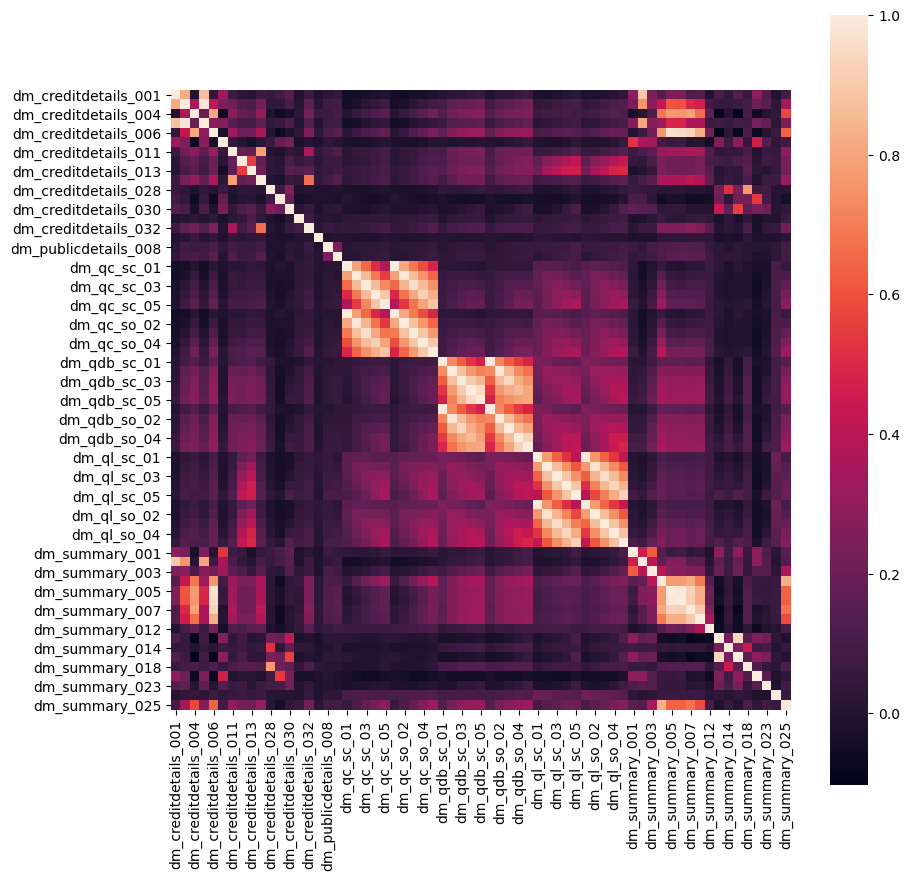

In [76]:
cor_var = hf_parsed.select_dtypes('number').columns.difference(['id','dm_summary_022', 'dm_publicdetails_001', 
                                                                'dm_publicdetails_002', 'dm_publicdetails_003', 'dm_creditdetails_024' ])
correlation = hf_parsed[cor_var].corr()
plt.close()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=False, square=True)
plt.show()

## 标签处理

In [87]:
loan_good = pd.read_csv("./data/loan_good_202302241703.csv")
loan_good['label'] = 0
loan_bad = pd.read_csv("./data/loan_bad_202302241702.csv")
loan_bad['label'] = 1
loan = pd.concat([loan_good, loan_bad])
loan_user = pd.read_csv("./data/loan_user_202302241703.csv")
loan = loan.merge(loan_user, on = ['user_id'], how='left')
loan = loan.query('product_name != "灰度测试"')
peek(loan, 2)

(1306, 9)
             order_no  user_id  withdraw_amount            loan_time  \
7  205068627878219842       29           1000.0  2022-07-20 13:09:49   
8  205374302734913622       43           1000.0  2022-07-21 09:24:28   

  product_name  total_cycle  label  pay_cnt          customer_unique_key  
7          银信金           12      0      NaN  C20220720205066554575032370  
8          银信金            6      0      NaN  C20220721205244862285615186  


- 原始数据有1059条阴性，247条阳性数据，评估模型指标可以根据需要选择auc, precision, recall, f1等
- 因为存在复贷数据，去重后有813条数据

In [7]:
loan['label'].value_counts()

0    1059
1     247
Name: label, dtype: int64

In [40]:
loan['customer_unique_key'].nunique()

813

每个客户只有1个label，说明复贷客户在不同的放款订单上逾期行为一致，即要不都逾期，要不都没有逾期

In [12]:
loan.groupby('customer_unique_key').filter(lambda x: x['label'].nunique() > 1)['customer_unique_key']

Series([], Name: customer_unique_key, dtype: object)

In [50]:
hf_parsed[hf_parsed['customer_unique_key'].isin(loan['customer_unique_key'])]['customer_unique_key'].nunique()

565

In [2]:
print("git test")

git test


In [3]:
print("git test again")

git test again
